In [2]:
import utils as u
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib widget

with open('modal_m2.pkl', 'rb') as f:
    modal_analysis_m2 = pickle.load(f)

modal_analysis_m2

{'table': 'Medium_2',
 'freq': array([ 107.10948395,  163.23095752,  190.08309549,  265.82420397,
         413.32492738,  429.22435964,  460.3127441 ,  533.20198911,
         604.01337104,  695.29091868,  759.97819446,  816.23792143,
         872.90451175,  909.54290049, 1043.62761363, 1094.67159299]),
 'xi': array([-0.00047083, -0.00145648, -0.00049255, -0.0005672 , -0.00230934,
        -0.00095988, -0.00097942, -0.00089937, -0.00139964, -0.00097538,
        -0.00114418, -0.00212587, -0.00222287, -0.00130497, -0.00170031,
        -0.0036397 ]),
 'ratios': array([ 1.        ,  1.52396363,  1.77466167,  2.48179894,  3.8589013 ,
         4.00734224,  4.29759091,  4.97810249,  5.63921465,  6.49140387,
         7.09533989,  7.62059429,  8.14964725,  8.4917121 ,  9.74355935,
        10.22011826]),
 'xi_mod': array([-0.11253203, -0.22842412, -0.06633512, -0.05462377, -0.14303315,
        -0.05724961, -0.05446982, -0.04318039, -0.05932118, -0.03591255,
        -0.03854191, -0.06667452, -0.065

In [3]:
def calcul_e_nu(omega,Lx,Ly,rapport):
    return(rapport * omega**2 / (((np.pi/Lx)**2 + (np.pi/Ly)**2)**2)   )


In [4]:
Lx = 0.40
Ly = 0.26

fond_m2 = 107.10948395
h_m2 = 6.04e-3 
masse_m2 = 507e-3
rho_m2 = masse_m2 / (Lx * Ly * h_m2)
Rapport_m2 = 12 * rho_m2 / h_m2**2
E_nu_m2 =  calcul_e_nu(2*np.pi*fond_m2,Lx,Ly,Rapport_m2)

In [5]:
def omega_pq (p,q,h,E_nu,rho,Lx,Ly) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
    return np.sqrt(E_nu*h**2/(12*rho)) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

def phi_pq (p,q,x,y, Lx, Ly) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
    """
    ## Inputs
    - p : numéro du mode selon x
    - q : numéro du mode selon y
    - x : arrayLike, vecteur des abscisses
    - y : arrayLike, vecteur des ordonnées

    ## Outputs
    - phi_pq : arrayLike, size (Nx,Ny), déformée du mode (p,q) en tous les points (x,y) du maillage
    """
    return np.sin(p*np.pi*x[:,np.newaxis]/Lx)*np.sin(q*np.pi*y[np.newaxis,:]/Ly)

def f_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 

    return(wnB/2/np.pi)
def mode_plaque(Lx,Ly,h,E_nu,rhoT):
    NB, MB = 3, 3 #Nombre de modes selon x, y
    NmB = NB * MB   #Nombre de modes total considéré dans le modèle de plaque

    dx, dy = 10e-3, 10e-3
    x, y = np.arange(0,Lx,dx), np.arange(0,Ly,dy)
    Nx, Ny = len(x), len(y)
    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m, h, E_nu,rhoT,Lx,Ly)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant 
    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        n, m = NmB_idx[0,mode], NmB_idx[1,mode]
        phiB_NxNy_NmB[:,mode] = phi_pq(n, m , x, y, Lx, Ly).ravel()

    return(wnB/2/np.pi,phiB_NxNy_NmB,x,y)

##phiB_NxNy_NmB[:,j],(Nx,Ny)

In [6]:
f_base,phiB_NxNy_NmB,x,y = mode_plaque(Lx,Ly,h_m2,E_nu_m2,rho_m2)
Nx = len(x)
Ny = len(y)

In [7]:
X_che1 = 13 
Y_che1 = 8

X_che2 = 19
Y_che2 = 11

In [8]:
from data_loader import *

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


{'0': 'Metal', '1': 'Medium_1', '2': 'Plexi', '3': 'Medium_2'}


In [9]:
idx_mat = 3 #Je choisis le matériau d'indice 1

dico_pos1 = deforme_Nta_Npos[idx_mat,0]
dico_pos2 = deforme_Nta_Npos[idx_mat,1]

freq1 = dico_pos1['freq']
FRF1 = dico_pos1['FRF']

freq2 = dico_pos2['freq']
FRF2 = dico_pos2['FRF']

f_fond = modal_analysis_m2['freq']

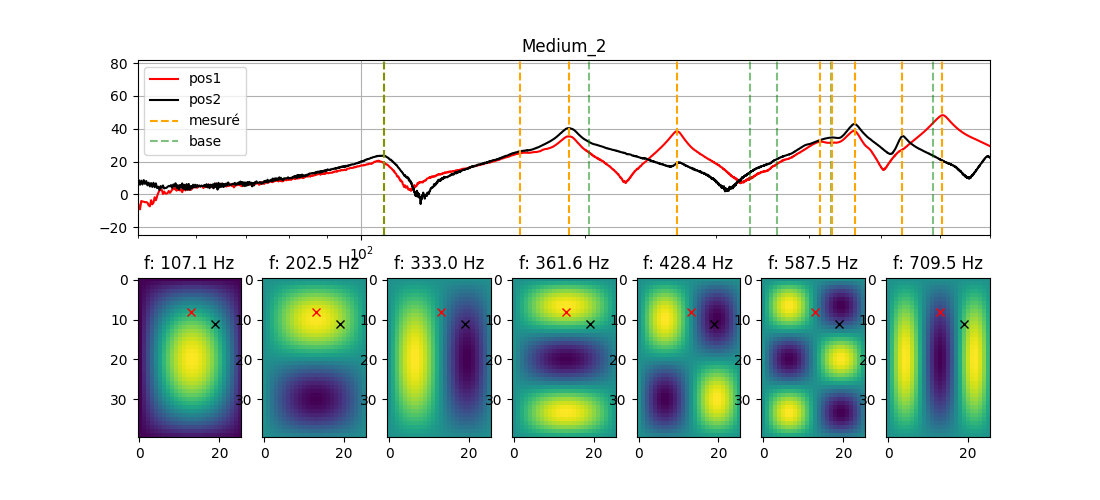

In [10]:
N_mode= 7
plt.figure(figsize=(11,5))
a1 = plt.subplot2grid((2,N_mode),(0,0),colspan = N_mode)
a1.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
a1.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
a1.set_title(dico_pos1["mat_table"])
a1.axvline(f_fond[0],ls='--',color='orange',label='mesuré')
a1.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    a1.axvline(f_fond[i],ls='--',color='orange')
    a1.axvline(f_base[i],ls='--',color='green',alpha=0.5)

a1.grid()
a1.legend()
a1.set_xlim(50,700)
for i in range(N_mode):
    ax = plt.subplot2grid((2,N_mode),(1,i),rowspan = 1, colspan = 1)
    ax.imshow(np.reshape(phiB_NxNy_NmB[:,i],(Nx,Ny)))
    ax.plot(X_che1,Y_che1,'rx',label='pos1')
    ax.plot(X_che2,Y_che2,'kx',label='pos2')
    ax.set_title(f'f: {f_base[i]:0.1f} Hz')
plt.show()

In [52]:
#f_bon = [f_fond[0],f_fond[2]]
f_bon = [f_fond[0],f_fond[2],f_fond[3]]
print(f_bon)

[107.10948395, 190.08309549, 265.82420397]


In [19]:
f_fond

array([ 107.10948395,  163.23095752,  190.08309549,  265.82420397,
        413.32492738,  429.22435964,  460.3127441 ,  533.20198911,
        604.01337104,  695.29091868,  759.97819446,  816.23792143,
        872.90451175,  909.54290049, 1043.62761363, 1094.67159299])

In [56]:
def optimisation(f_bon,h,E_nu,rhoT,Lx,Ly,plot=False):
    pourcentage = 0.30
    idx_max = len(f_bon)
    XX = np.linspace(Lx*(1 - pourcentage),Lx*(1+pourcentage),100)
    YY = np.linspace(Ly*(1 - pourcentage),Ly*(1+pourcentage),100)
    ZZ = np.linspace(E_nu*(1 - pourcentage),E_nu*(1+pourcentage),100)
    cout = np.zeros((len(XX),len(YY),len(ZZ)))

    pondération = [50,25]
    pondération = np.concatenate((pondération,[1]*(len(f_bon)-2)))
    #pondération = np.ones_like(f_bon)
    for ii,i in enumerate(XX) :
        for jj,j in enumerate(YY):
            for zz,z in enumerate(ZZ):
                f_optim = f_plaque(i,j,h,z,rhoT)
                cout[ii,jj,zz] = np.sum(np.abs(pondération * (f_bon - f_optim[:idx_max])))
            

    xxx, yyy,zzz=  np.unravel_index(cout.argmin(), cout.shape)
    Lx_final, Ly_final, E_nu_finale = XX[xxx],YY[yyy], ZZ[zzz]
    if plot :
        extent = np.min(YY), np.max(YY), np.min(XX), np.max(XX)
        plt.figure()        
        plt.scatter(YY[yyy],XX[xxx],label="point choisi")
        plt.imshow(1-cout/np.max(cout),cmap='inferno',extent=extent)
        plt.xlabel("Variation en Y")
        plt.ylabel("Variation en X")
        plt.legend()
        plt.title("Fonction de cout en fonction des valeurs de X et de Y")
        plt.colorbar()
        plt.show()
        
    return(Lx_final, Ly_final,E_nu_finale,cout)
            


In [57]:
Lx_op,Ly_op,E_nu_finale,cout = optimisation(f_bon,h_m2,E_nu_m2,rho_m2,Lx,Ly)
Lx_op,Ly_op,E_nu_finale

(0.4206060606060606, 0.24818181818181817, 2576534079.3792567)

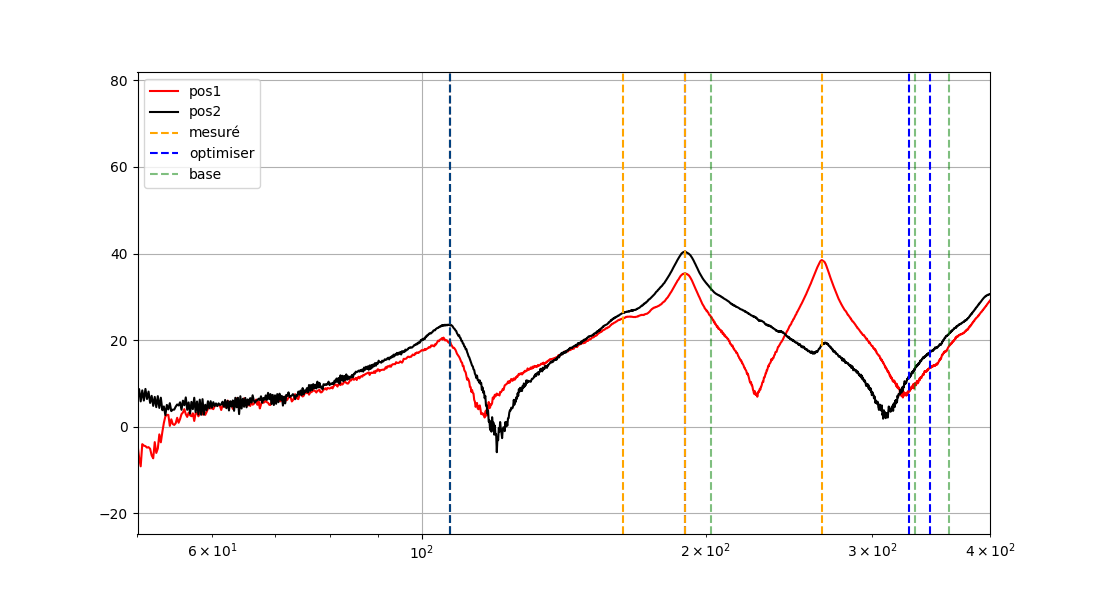

In [58]:
f_op = f_plaque(Lx_op, Ly_op,h_m2,E_nu_finale,rho_m2)
plt.figure(figsize = (11,6))
plt.semilogx(freq1,20*np.log10(np.abs(FRF1)),'r',label='pos1')
plt.semilogx(freq2,20*np.log10(np.abs(FRF2)),'k',label='pos2')
plt.axvline(f_fond[0],ls='--',color='orange',label = 'mesuré')
plt.axvline(f_op[0],ls='--',color='blue',label="optimiser")
plt.axvline(f_base[0],ls='--',color='green',label="base",alpha=0.5)
for i in range(1,min(len(f_fond),len(f_base))):
    plt.axvline(f_fond[i],ls='--',color='orange')
    plt.axvline(f_op[i],ls='--',color='blue')
    plt.axvline(f_base[i],ls='--',color='green',alpha=0.5)
plt.grid()
plt.legend()
plt.xlim(50,400)
plt.show()

In [60]:
import pandas as pd
pd.DataFrame(modal_analysis_m2)

[0.112532,0.066335,0.054624,0.143033,0.057250,0.043180,0.038542,0.066675,0.036730]

,table,freq,xi,ratios,xi_mod
0,Medium_2,107.109484,-0.000471,1.000000,-0.112532
1,Medium_2,163.230958,-0.001456,1.523964,-0.228424
2,Medium_2,190.083095,-0.000493,1.774662,-0.066335
3,Medium_2,265.824204,-0.000567,2.481799,-0.054624
4,Medium_2,413.324927,-0.002309,3.858901,-0.143033
5,Medium_2,429.224360,-0.000960,4.007342,-0.057250
6,Medium_2,460.312744,-0.000979,4.297591,-0.054470
7,Medium_2,533.201989,-0.000899,4.978102,-0.043180
8,Medium_2,604.013371,-0.001400,5.639215,-0.059321
9,Medium_2,695.290919,-0.000975,6.491404,-0.035913


Valeur gardé : 

Lx = 0.4206060606060606

Ly = 0.24818181818181817

E_nu = 2576534079.3792567

xinB = [0.112532,0.066335,0.054624,0.143033,0.057250,0.043180,0.038542,0.066675,0.036730]


In [ ]:
xinB = [0.112532,0.066335,0.054624,0.143033,0.057250,0.043180,0.038542,0.066675,0.036730]
f_op 
phiB_NxNy_NmB
X_che1,Y_che1

In [64]:
import mymodule2 as m

In [68]:
X_che1

13

In [72]:
x_idx = m.find_nearest_index(x,X_che1*1e-2)
y_idx = m.find_nearest_index(y,Y_che1*1e-2)

In [74]:
phiB_Nx_Ny_NmB = phiB_NxNy_NmB.reshape((Nx,Ny,-1))

(40, 26, 9)

In [63]:
freq1

array([0.00000000e+00, 1.95312500e-01, 3.90625000e-01, ...,
       2.55994141e+04, 2.55996094e+04, 2.55998047e+04])

In [75]:
wn = f_op*2*np.pi

In [ ]:
FRF_model = np.zeros(len(freq1))
for i in range(len(freq1)) :
    FRF_model[i] = - (freq1[i]*2*np.pi)**2 * np.sum(phiB_Nx_Ny_NmB[x_idx,y_idx,:]**2/wn**2)